<div style="text-align: center; font-size: 20px; font-weight: bold;">
<h1>Skforecast: introduction to time series forecasting with machine learning</h1>
</div>

<br>

<div style="text-align: center;">
    <img src="https://github.com/skforecast/skforecast/raw/master/docs/img/banner-landing-page-skforecast.png" style="display: block; margin: 0 auto;">
</div>

## Introduction

This document shows how to crteate forecasting models utilizing machine learning:

+ Creating a forecaster model with `skforecast`  and `LightGBM`.

+ Forecasting future values.

+ Exogenous variables.

+ Validating the model with backtesting.

+ Optimizing the model with hyperparameter tuning.

+ Feature selection.

+ Probabilistic forecasting.

+ Model explanability.

## Libraries

In [2]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
import plotly.graph_objects as go
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size':8})

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.feature_selection import select_features
from skforecast.model_selection import TimeSeriesFold
from sklearn.metrics import mean_absolute_error

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

## Data

A time series of electricity demand (MW) is available for the state of Victoria (Australia) from 2011-12-31 to 2014-12-31 is available. The data used in this document has been obtained from the **R** [tsibbledata]("https://tsibbledata.tidyverts.org") package. The dataset contains 5 columns and 52,608 complete records. The information in each column is:

+ Time: date and time of the record.
+ Date: date of the record.
+ Demand: electricity demand (MW).
+ Temperature: temperature in Melbourne, the capital of Victoria.
+ Holiday: indicates if the day is a public holiday.

In [3]:
# Data download
# ==============================================================================
data = fetch_dataset(name='vic_electricity')
data = data.drop(columns="Date")
data.head(5)

vic_electricity
---------------
Half-hourly electricity demand for Victoria, Australia
O'Hara-Wild M, Hyndman R, Wang E, Godahewa R (2022).tsibbledata: Diverse
Datasets for 'tsibble'. https://tsibbledata.tidyverts.org/,
https://github.com/tidyverts/tsibbledata/.
https://tsibbledata.tidyverts.org/reference/vic_elec.html
Shape of the dataset: (52608, 4)


,Demand,Temperature,Holiday
Time,,,
2011-12-31 13:00:00,4382.825174,21.40,True
2011-12-31 13:30:00,4263.365526,21.05,True
2011-12-31 14:00:00,4048.966046,20.70,True
2011-12-31 14:30:00,3877.563330,20.55,True
2011-12-31 15:00:00,4036.229746,20.40,True


In [4]:
# Verify index is complete
# ==============================================================================
start_date = data.index.min()
end_date = data.index.max()
complete_date_range = pd.date_range(start=start_date, end=end_date, freq=data.index.freq)
is_index_complete = (data.index == complete_date_range).all()
print(f"Index complete: {is_index_complete}")
print(f"Number of rows with missing values: {data.isnull().any(axis=1).mean()}")

Index complete: True
Number of rows with missing values: 0.0


In [5]:
# Fill gaps in a temporary index
# ==============================================================================
# data.asfreq(freq='30min', fill_value=np.nan)

`label='left/right'` and `closed='left'/'right`. 

+ 10:00 includes data from 10:00 - 11:00 (left)

+ 11:00 includes data from 10:00 - 11:00 (right)

+ `closed=left`

<div style="text-align: center;">
    <img src="https://github.com/skforecast/skforecast/raw/master/docs/img/diagram_resampling_datetime.png" style="display: block; margin: 0 auto; width: 50%;">
</div>

In [6]:
# Aggregating in 1H intervals
# ==============================================================================
data = data.resample(rule="h", closed="left", label="right").agg({
    "Demand": "mean",
    "Temperature": "mean",
    "Holiday": "mean",
})
data

,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0
2011-12-31 15:00:00,3963.264688,20.625,1.0
2011-12-31 16:00:00,3950.913495,20.325,1.0
2011-12-31 17:00:00,3627.860675,19.850,1.0
2011-12-31 18:00:00,3396.251676,19.025,1.0
...,...,...,...
2014-12-31 09:00:00,4069.625550,21.600,0.0
2014-12-31 10:00:00,3909.230704,20.300,0.0
2014-12-31 11:00:00,3900.600901,19.650,0.0


In [7]:
# Split data into train-val-test
# ==============================================================================
data = data.loc['2012-01-01 00:00:00':'2014-12-30 23:00:00', :].copy()
end_train = '2013-12-31 23:59:00'
end_validation = '2014-11-30 23:59:00'
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2012-01-01 00:00:00 --- 2013-12-31 23:00:00  (n=17544)
Validation dates : 2014-01-01 00:00:00 --- 2014-11-30 23:00:00  (n=8016)
Test dates       : 2014-12-01 00:00:00 --- 2014-12-30 23:00:00  (n=720)


## Graphic exploration

In [8]:
# Interactive plot of time series
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['Demand'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=data_val.index, y=data_val['Demand'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['Demand'], mode='lines', name='Test'))
fig.update_layout(
    title='Hourly energy demand',
    xaxis_title="Time",
    yaxis_title="Demand",
    legend_title="Partition:",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1, xanchor="left", x=0.001)
)
fig.show()

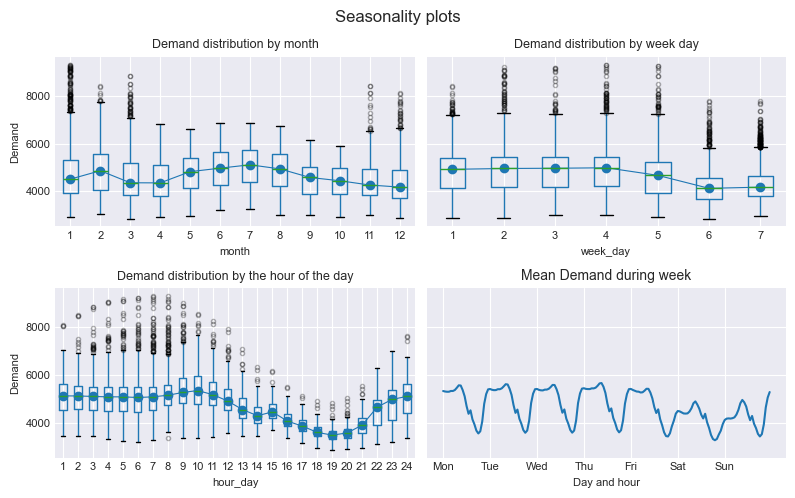

In [9]:
# Annual, weekly and daily seasonality
# ==============================================================================
fig, axs = plt.subplots(2, 2, figsize=(8, 5), sharex=False, sharey=True)
axs = axs.ravel()

# Demand distribution by month
data['month'] = data.index.month
data.boxplot(column='Demand', by='month', ax=axs[0], flierprops={'markersize': 3, 'alpha': 0.3})
data.groupby('month')['Demand'].median().plot(style='o-', linewidth=0.8, ax=axs[0])
axs[0].set_ylabel('Demand')
axs[0].set_title('Demand distribution by month', fontsize=9)

# Demand distribution by week day
data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='Demand', by='week_day', ax=axs[1], flierprops={'markersize': 3, 'alpha': 0.3})
data.groupby('week_day')['Demand'].median().plot(style='o-', linewidth=0.8, ax=axs[1])
axs[1].set_ylabel('Demand')
axs[1].set_title('Demand distribution by week day', fontsize=9)

# Demand distribution by the hour of the day
data['hour_day'] = data.index.hour + 1
data.boxplot(column='Demand', by='hour_day', ax=axs[2], flierprops={'markersize': 3, 'alpha': 0.3})
data.groupby('hour_day')['Demand'].median().plot(style='o-', linewidth=0.8, ax=axs[2])
axs[2].set_ylabel('Demand')
axs[2].set_title('Demand distribution by the hour of the day', fontsize=9)

# Demand distribution by week day and hour of the day
mean_day_hour = data.groupby(["week_day", "hour_day"])["Demand"].mean()
mean_day_hour.plot(ax=axs[3])
axs[3].set(
    title       = "Mean Demand during week",
    xticks      = [i * 24 for i in range(7)],
    xticklabels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel      = "Day and hour",
    ylabel      = "Number of Demand"
)
axs[3].title.set_size(10)

fig.suptitle("Seasonality plots", fontsize=12)
fig.tight_layout()

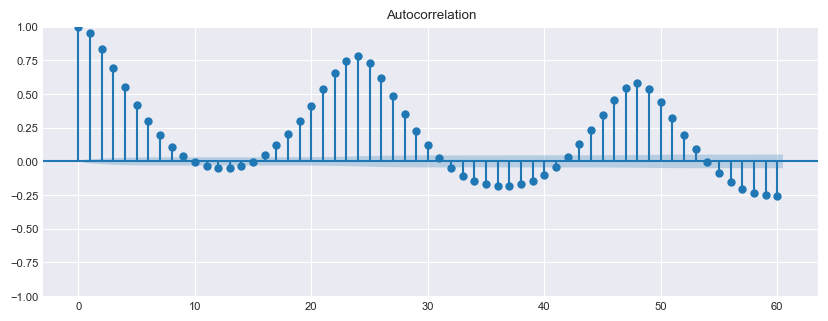

In [15]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 3.5))
plot_acf(data.Demand, ax=ax, lags=60)
plt.show()

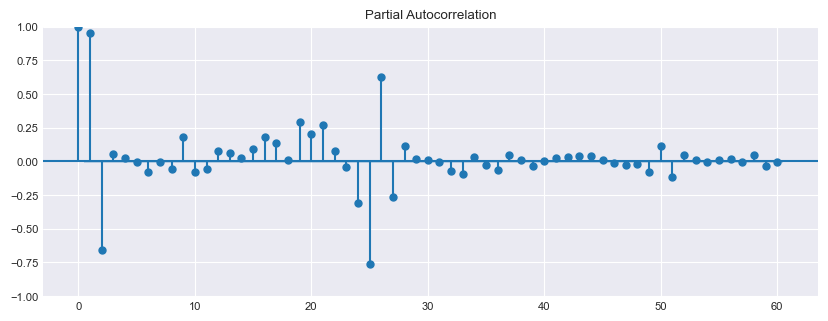

In [16]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 3.5))
plot_pacf(data.Demand, ax=ax, lags=60)
plt.show()

In [34]:
# Compute the PACF values
# ==============================================================================
nlags = 60

pacf_values = pd.DataFrame({
    'lag': range(0, nlags + 1)[1:],
    'pacf': pacf(data['Demand'], nlags=nlags)[1:]
}).sort_values(by='pacf', ascending=False)

print("10 most important lags:")
pacf_values.head(10)

10 most important lags:


,lag,pacf
0,1,0.949526
25,26,0.634868
18,19,0.291113
20,21,0.269274
19,20,0.201192
8,9,0.184975
15,16,0.177593
16,17,0.136279
27,28,0.127166
49,50,0.107496


## Recursive multi-step forecasting

A recursive autoregressive model [`ForecasterRecursive`](https://skforecast.org/latest/user_guides/autoregresive-forecaster.html) is trained using a gradient boosting regressor [LGBMRegressor](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html), to predict energy demand for the next 24 hours.

The predictors used are the demand values from the past 24 hours (24 lags). The regressor's hyperparameters are left at their default values.

### Create and fit a forecaster

In [50]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 24 # From 1 to 24
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_validation, 'Demand'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window features: None 
Window size: 24 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-12-16 14:30:33 
Last fit date: 2024-12-16 14:30:33 
Skforecast version: 0.14.0 
Python version: 3.11.10 
Forecaster id: None

In [51]:
# Internal training matrices
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(data.loc[:end_validation, 'Demand'])
display(X_train.head(3))
display(y_train.head(3))

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
Time,,,,,,,,,,,,,,,,,,,,,
2012-01-02 00:00:00,4732.831353,4213.169379,3841.520434,3530.436335,3434.336671,3425.274352,3545.744810,3858.743655,3825.128319,4265.965213,...,5799.923228,6043.968927,6035.531240,5883.466508,5689.246067,5487.388289,5270.116328,5009.466997,4685.820480,4329.049863
2012-01-02 01:00:00,5262.895338,4732.831353,4213.169379,3841.520434,3530.436335,3434.336671,3425.274352,3545.744810,3858.743655,3825.128319,...,5462.652199,5799.923228,6043.968927,6035.531240,5883.466508,5689.246067,5487.388289,5270.116328,5009.466997,4685.820480
2012-01-02 02:00:00,5786.043417,5262.895338,4732.831353,4213.169379,3841.520434,3530.436335,3434.336671,3425.274352,3545.744810,3858.743655,...,5302.362170,5462.652199,5799.923228,6043.968927,6035.531240,5883.466508,5689.246067,5487.388289,5270.116328,5009.466997


Time
2012-01-02 00:00:00    5262.895338
2012-01-02 01:00:00    5786.043417
2012-01-02 02:00:00    6236.144167
Freq: h, Name: y, dtype: float64

### Predict

+ Predictions automatically include the date and time of the forecast.

+ If no `last_window` is provided, predictions will start right after the last training point.

+ If `last_window` is provided, predictions will start right after the last point in the `last_window`.

In [52]:
# Prediction
# ==============================================================================
steps = 10
forecaster.predict(steps=steps, last_window=None)

2014-12-01 00:00:00    5590.819530
2014-12-01 01:00:00    5530.118575
2014-12-01 02:00:00    5480.472005
2014-12-01 03:00:00    5459.493236
2014-12-01 04:00:00    5392.936759
2014-12-01 05:00:00    5362.001338
2014-12-01 06:00:00    5389.917593
2014-12-01 07:00:00    5516.648118
2014-12-01 08:00:00    5681.892640
2014-12-01 09:00:00    5656.123499
Freq: h, Name: pred, dtype: float64

In [53]:
# Prediction with last_window
# ==============================================================================
steps = 10
last_window = data.iloc[-24:, 0]
last_window

Time
2014-12-30 00:00:00    4123.096761
2014-12-30 01:00:00    4097.756854
2014-12-30 02:00:00    4091.561106
2014-12-30 03:00:00    4047.943729
2014-12-30 04:00:00    4038.375743
2014-12-30 05:00:00    4049.818067
2014-12-30 06:00:00    4160.460319
2014-12-30 07:00:00    4309.887910
2014-12-30 08:00:00    4262.002120
2014-12-30 09:00:00    4131.922608
2014-12-30 10:00:00    4055.468880
2014-12-30 11:00:00    4107.019304
2014-12-30 12:00:00    3884.043837
2014-12-30 13:00:00    3752.128810
2014-12-30 14:00:00    4090.640341
2014-12-30 15:00:00    3783.067633
2014-12-30 16:00:00    3492.526208
2014-12-30 17:00:00    3278.870502
2014-12-30 18:00:00    3201.746822
2014-12-30 19:00:00    3307.042391
2014-12-30 20:00:00    3527.232855
2014-12-30 21:00:00    3846.439766
2014-12-30 22:00:00    3961.529675
2014-12-30 23:00:00    4059.288011
Freq: h, Name: Demand, dtype: float64

<div style="text-align: center;">
    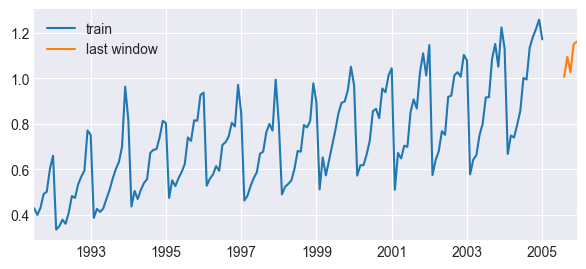
</div>

In [54]:
# Prediction with last_window
# ==============================================================================
forecaster.predict(steps=steps, last_window=last_window)

2014-12-31 00:00:00    4052.718526
2014-12-31 01:00:00    4018.786208
2014-12-31 02:00:00    3981.469779
2014-12-31 03:00:00    3957.617085
2014-12-31 04:00:00    3976.378202
2014-12-31 05:00:00    4027.492779
2014-12-31 06:00:00    4144.493565
2014-12-31 07:00:00    4293.704484
2014-12-31 08:00:00    4380.426626
2014-12-31 09:00:00    4150.290286
Freq: h, Name: pred, dtype: float64

### Metrics

In [55]:
# Metric calculation
# ==============================================================================
predictions = forecaster.predict(steps=steps)
mean_absolute_error(
    y_true = data.loc[end_validation:'2014-12-01 09:00:00', 'Demand'],
    y_pred = predictions
)

368.16936757975236

## Exogenous variables and window features

+ [Exogenous variables](https://skforecast.org/latest/user_guides/exogenous-variables)
+ [Calendar features](https://skforecast.org/latst/user_guides/calendar-features)
+ [Cyclical encoding](https://skforecast.org/latest/user_guides/calendar-features#cyclical-encoding)
+ [Window features](https://skforecast.org/last/user_guides/window-features-and-custom-features)

In [56]:
# Libraries
# ==============================================================================
from skforecast.preprocessing import RollingFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.timeseries.forecasting import WindowFeatures

In [57]:
# Calendar features
# ==============================================================================
features_to_extract = ["month", "week", "day_of_week", "hour"]
calendar_transformer = DatetimeFeatures(
    variables="index",
    features_to_extract=features_to_extract,
    drop_original=False,
)
data = calendar_transformer.fit_transform(data)

# Rolling windows of temperature
# ==============================================================================
wf_transformer = WindowFeatures(
    variables=["Temperature"],
    window=["3D"],
    functions=["mean", "max", "min"],
    freq="h",
)
data = wf_transformer.fit_transform(data)

# Remove heading nans due to the rolling window
# ==============================================================================
data = data.dropna()

exog_features = [
    "Temperature",
    "Holiday",
    "month",
    "week_day",
    "hour_day",
    "week",
    "day_of_week",
    "hour",
    "Temperature_window_3D_mean",
    "Temperature_window_3D_max",
    "Temperature_window_3D_min",
]

data.head(5)

,Demand,Temperature,Holiday,month,week_day,hour_day,week,day_of_week,hour,Temperature_window_3D_mean,Temperature_window_3D_max,Temperature_window_3D_min
Time,,,,,,,,,,,,
2012-01-01 01:00:00,4685.820480,29.650,1.0,1,7,2,52,6,1,27.000000,27.000,27.0
2012-01-01 02:00:00,5009.466997,31.650,1.0,1,7,3,52,6,2,28.325000,29.650,27.0
2012-01-01 03:00:00,5270.116328,32.675,1.0,1,7,4,52,6,3,29.433333,31.650,27.0
2012-01-01 04:00:00,5487.388289,32.300,1.0,1,7,5,52,6,4,30.243750,32.675,27.0
2012-01-01 05:00:00,5689.246067,31.000,1.0,1,7,6,52,6,5,30.655000,32.675,27.0


In [58]:
# Create and train forecaster
# ==============================================================================
window_features = RollingFeatures(stats=['mean', 'mean'], window_sizes=[24, 48])
forecaster = ForecasterRecursive(
                 regressor       = LGBMRegressor(random_state=123, verbose=-1),
                 lags            = 24,
                 window_features = window_features
             )

forecaster.fit(
    y=data.loc[:end_validation, "Demand"], exog=data.loc[:end_validation, exog_features]
)
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window features: ['roll_mean_24', 'roll_mean_48'] 
Window size: 48 
Exogenous included: True 
Exogenous names: 
    Temperature, Holiday, month, week_day, hour_day, week, day_of_week, hour,
    Temperature_window_3D_mean, Temperature_window_3D_max,
    Temperature_window_3D_min 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2012-01-01 01:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-12-16 14:30:34 
Last fit date: 2024-12-16 14:30:34 
Skforecast version: 0.14.0 
Python version: 3.11.10 
Forecaster id: None

In [59]:
# Internal training matrices
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(
    data.loc[:end_validation, "Demand"], data.loc[:end_validation, exog_features]
)
X_train.head(3)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,Holiday,month,week_day,hour_day,week,day_of_week,hour,Temperature_window_3D_mean,Temperature_window_3D_max,Temperature_window_3D_min
Time,,,,,,,,,,,,,,,,,,,,,
2012-01-03 01:00:00,6378.705137,6018.647209,5458.749989,4879.446053,4268.581681,3957.079905,3880.148671,4027.543405,4422.499490,4449.370426,...,0.0,1.0,2.0,2.0,1.0,1.0,1.0,29.120408,39.525,20.375
2012-01-03 02:00:00,6699.486540,6378.705137,6018.647209,5458.749989,4879.446053,4268.581681,3957.079905,3880.148671,4027.543405,4422.499490,...,0.0,1.0,2.0,3.0,1.0,1.0,2.0,29.066500,39.525,20.375
2012-01-03 03:00:00,6948.331814,6699.486540,6378.705137,6018.647209,5458.749989,4879.446053,4268.581681,3957.079905,3880.148671,4027.543405,...,0.0,1.0,2.0,4.0,1.0,1.0,3.0,29.022059,39.525,20.375


<div style="text-align: center; font-size: 30px; font-weight: bold; color: #f79939">
<h1>Back to the theory</h1>
</div>

## Backtesting

To obtain a robust estimate of the model's predictive ability, a backtesting process is performed. The backtesting process consists of generating a forecast for each observation in the test set, following the same procedure as would be done in production, and then comparing the predicted value to the actual value.

The backtesting process is applied using the `backtesting_forecaster()` function. For this use case, the simulation is carried out as follows: the model is trained with data from 2012-01-01 00:00 to 2014-11-30 23:59, and then it predicts the next 24 hours every day at 23:59. The error metric used is the Mean Absolute Error (MAE).


+ [Backtesting strategies](https://skforecast.org/latest/user_guides/backtesting)
+ [Backtesting with custom metrics](https://skforecast.org/0.14.0/user_guides/backtesting.html#backtesting-with-custom-metric)

In [60]:
# Define backtesting strategy
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24,
         initial_train_size = len(data[:end_validation]),
         refit              = False,
         verbose            = False
     )

cv.split(X=data['Demand'], as_pandas=True)

c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\skforecast\model_selection\_split.py:791: UserWarning:

Last window cannot be calculated because `window_size` is None.



,fold,train_start,train_end,last_window_start,last_window_end,test_start,test_end,test_start_with_gap,test_end_with_gap,fit_forecaster
0,0,0,25559,None,None,25559,25583,25559,25583,True
1,1,0,25559,None,None,25583,25607,25583,25607,False
2,2,0,25559,None,None,25607,25631,25607,25631,False
3,3,0,25559,None,None,25631,25655,25631,25655,False
4,4,0,25559,None,None,25655,25679,25655,25679,False
5,5,0,25559,None,None,25679,25703,25679,25703,False
6,6,0,25559,None,None,25703,25727,25703,25727,False
7,7,0,25559,None,None,25727,25751,25727,25751,False
8,8,0,25559,None,None,25751,25775,25751,25775,False
9,9,0,25559,None,None,25775,25799,25775,25799,False


In [61]:
# Backtest model on test data
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24,
         initial_train_size = len(data[:end_validation]), # train + validation
         refit              = False,
         verbose            = False
     )

metric, predictions = backtesting_forecaster(
                          forecaster    = forecaster,
                          y             = data['Demand'], # train + validation + test
                          cv            = cv,
                          metric        = 'mean_absolute_error',
                          n_jobs        = 'auto',
                          verbose       = False,  # Change to True to see more information
                          show_progress = True
                      )
predictions.head()

  0%|          | 0/30 [00:00<?, ?it/s]

,pred
2014-12-01 00:00:00,5613.116757
2014-12-01 01:00:00,5558.880640
2014-12-01 02:00:00,5537.483604
2014-12-01 03:00:00,5579.601421
2014-12-01 04:00:00,5569.791767


In [62]:
# Plot predictions vs real value
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['Demand'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Demand",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1.01, xanchor="left", x=0)
)
fig.show()

In [63]:
# Backtesting error
# ==============================================================================
metric

,mean_absolute_error
0,238.706876


## Hyperparameter tuning

The trained `ForecasterRecursive` object used the first 24 lags and a `LGMBRegressor` model with the default hyperparameters. However, there is no reason why these values are the most appropriate. To find the best hyperparameters, a [Bayesian Search](https://skforecast.org/latest/user_guides/hyperparameter-tuning-and-lags-selection#bayesian-search) is performed using the `bayesian_search_forecaster()` function. The search is carried out using the same backtesting process as before, but each time, the model is trained with different combinations of hyperparameters and lags. It is important to note that the hiperparameter search must be done using the validation set, so the test data is never used.

In [64]:
# Hyperparameters search
# ==============================================================================
window_features = RollingFeatures(stats=['mean', 'mean'], window_sizes=[24, 48])
forecaster = ForecasterRecursive(
                 regressor       = LGBMRegressor(random_state=123, verbose=-1),
                 lags            = 24,  # This value will be replaced in the grid search
                 window_features = window_features
             )

# Lags used as predictors
lags_grid = [24, (1, 2, 3, 23, 24, 25, 47, 48, 49)]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 600, 2000, step=100),
        'max_depth'     : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'          : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

# Folds training and validation
cv_search = TimeSeriesFold(
                steps              = 24,
                initial_train_size = len(data[:end_train]),
                refit              = False,
            )

results_search, frozen_trial = bayesian_search_forecaster(
                                   forecaster    = forecaster,
                                   y             = data.loc[:end_validation, 'Demand'], # Test data do not participate in the search
                                   cv            = cv_search,
                                   metric        = 'mean_absolute_error',
                                   search_space  = search_space,
                                   n_trials      = 10, # Increase for more exhaustive search
                                   random_state  = 123,
                                   return_best   = True,
                                   n_jobs        = 'auto',
                                   verbose       = False,
                                   show_progress = True
                               )

  0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
  Parameters: {'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.05513142057308684, 'reg_alpha': 0.4, 'reg_lambda': 0.4}
  Backtesting metric: 233.76073021791416


In [65]:
# Search results
# ==============================================================================
best_params = results_search.at[0, 'params']
best_params = best_params | {'random_state': 15926, 'verbose': -1}
best_lags = results_search.at[0, 'lags']
results_search.head(3)

,lags,params,mean_absolute_error,n_estimators,max_depth,learning_rate,reg_alpha,reg_lambda
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1000, 'max_depth': 8, 'learni...",233.760730,1000.0,8.0,0.055131,0.4,0.4
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 1600, 'max_depth': 6, 'learni...",244.129063,1600.0,6.0,0.202138,0.3,0.8
2,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'n_estimators': 1600, 'max_depth': 9, 'learni...",252.556759,1600.0,9.0,0.050766,0.8,0.2


Since `return_best` has been set to `True`, the forecaster object is automatically updated with the best configuration found and trained on the entire dataset. This final model can then be used for future predictions on new data.

In [66]:
# Best model
# ==============================================================================
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window features: ['roll_mean_24', 'roll_mean_48'] 
Window size: 48 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2012-01-01 01:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.05513142057308684,
    'max_depth': 8, 'min_child_samples': 20, 'min_child_weight': 0.001,
    'min_split_gain': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'num_leaves':
    31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.4, 'reg_lambda':
    0.4, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0,
    'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-12-16 14:30:35 
Last fit date: 2024-12-16 14:31:38 
Skforecast version: 0.14.0 
Python version: 3.11.10 
Forecaster id: None

In [67]:
# Backtest final model on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster    = forecaster,
                          y             = data['Demand'],
                          exog          = None,
                          cv            = cv,
                          metric        = 'mean_absolute_error',
                          n_jobs        = 'auto',
                          verbose       = False, # Change to True to see detailed information
                          show_progress = True
                      )
metric

  0%|          | 0/30 [00:00<?, ?it/s]

,mean_absolute_error
0,203.460579


In [ ]:
238.706876 -> 203.460579

## Feature selection

In [68]:
from sklearn.feature_selection import RFECV

In [69]:
# Create forecaster
# ==============================================================================
regressor = LGBMRegressor(
                n_estimators = 100,
                max_depth    = 5,
                random_state = 15926,
                verbose      = -1
            )

window_features = RollingFeatures(stats=['mean', 'mean'], window_sizes=[24, 48])
forecaster = ForecasterRecursive(
                 regressor       = regressor,
                 lags            = 24,
                 window_features = window_features
             )

# Recursive feature elimination with cross-validation
# ==============================================================================
selector = RFECV(
    estimator = regressor,
    step      = 1,
    cv        = 3,
    n_jobs    = -1
)
lags_select, window_features_select, exog_select = select_features(
    forecaster      = forecaster,
    selector        = selector,
    y               = data.loc[:end_train, 'Demand'],
    exog            = data.loc[:end_train, exog_features],
    select_only     = None, # 'autoreg', 'exog'
    force_inclusion = None,
    subsample       = 0.5, # Subsample to speed up the process
    random_state    = 123,
    verbose         = True,
)

Recursive feature elimination (RFECV)
-------------------------------------
Total number of records available: 17495
Total number of records used for feature selection: 8747
Number of features available: 37
    Lags            (n=24)
    Window features (n=2)
    Exog            (n=11)
Number of features selected: 18
    Lags            (n=13) : [1, 2, 3, 4, 8, 10, 13, 14, 18, 20, 22, 23, 24]
    Window features (n=0) : []
    Exog            (n=5) : ['Temperature', 'week_day', 'hour_day', 'week', 'Temperature_window_3D_mean']


The forecaster is trained and re-evaluated using the best subset of features.

In [70]:
# Create a forecaster with the selected features
# ==============================================================================
# window_features = RollingFeatures(stats=['mean'], window_sizes=[24])
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(**best_params),
                 lags      = lags_select
             )

# Backtesting model with exogenous variables on test data
# ==============================================================================
cv = TimeSeriesFold(
         steps              = 24,
         initial_train_size = len(data[:end_validation]),
         refit              = False,
         verbose            = False
     )

metric, predictions = backtesting_forecaster(
                          forecaster    = forecaster,
                          y             = data['Demand'],
                          exog          = data[exog_select],
                          cv            = cv,
                          metric        = 'mean_absolute_error',
                          n_jobs        = 'auto',
                          verbose       = False,
                          show_progress = True
                      )                
metric

  0%|          | 0/30 [00:00<?, ?it/s]

,mean_absolute_error
0,161.414807


In [ ]:
# Optimiation path
238.706876 -> 203.460579 -> 161.414807

<div style="text-align: center; font-size: 30px; font-weight: bold; color: #f79939">
<h1>Back to the theory</h1>
</div>

## Model explanaibility and interpretability

In [71]:
import shap

In [72]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(**best_params),
                 lags      = lags_select
             )

forecaster.fit(
    y    = data.loc[:end_validation, 'Demand'],
    exog = data.loc[:end_validation, exog_select]
)

### Model-specific feature importance

In [73]:
# Model-specific feature importances
# ==============================================================================
feature_importances = forecaster.get_feature_importances()
feature_importances.head(10)

,feature,importance
0,lag_1,3376
15,hour_day,2532
16,week,2209
13,Temperature,1935
12,lag_24,1771
1,lag_2,1736
17,Temperature_window_3D_mean,1705
4,lag_8,1508
8,lag_18,1446
5,lag_10,1438


### Shap values

In [74]:
# Training matrices used by the forecaster to fit the internal regressor
# ==============================================================================
X_train, y_train = forecaster.create_train_X_y(
                       y    = data.loc[:end_train, 'Demand'],
                       exog = data.loc[:end_train, exog_select]
                   )

display(X_train.head(3))
display(y_train.head(3))

,lag_1,lag_2,lag_3,lag_4,lag_8,lag_10,lag_13,lag_14,lag_18,lag_20,lag_22,lag_23,lag_24,Temperature,week_day,hour_day,week,Temperature_window_3D_mean
Time,,,,,,,,,,,,,,,,,,
2012-01-02 01:00:00,5262.895338,4732.831353,4213.169379,3841.520434,3545.744810,3825.128319,4860.374411,5302.362170,6035.531240,5689.246067,5270.116328,5009.466997,4685.820480,34.500,1.0,2.0,1.0,26.595000
2012-01-02 02:00:00,5786.043417,5262.895338,4732.831353,4213.169379,3425.274352,3858.743655,4422.765949,4860.374411,6043.968927,5883.466508,5487.388289,5270.116328,5009.466997,36.725,1.0,3.0,1.0,26.899038
2012-01-02 03:00:00,6236.144167,5786.043417,5262.895338,4732.831353,3434.336671,3545.744810,4265.965213,4422.765949,5799.923228,6035.531240,5689.246067,5487.388289,5270.116328,37.100,1.0,4.0,1.0,27.262963


Time
2012-01-02 01:00:00    5786.043417
2012-01-02 02:00:00    6236.144167
2012-01-02 03:00:00    6562.215878
Freq: h, Name: y, dtype: float64

In [75]:
# Create SHAP explainer (for three base models)
# ==============================================================================
shap.initjs()
explainer = shap.TreeExplainer(forecaster.regressor)

# Sample 50% of the data to speed up the calculation
rng = np.random.default_rng(seed=785412)
sample = rng.choice(X_train.index, size=int(len(X_train)*0.5), replace=False)
X_train_sample = X_train.loc[sample, :]
shap_values = explainer.shap_values(X_train_sample)

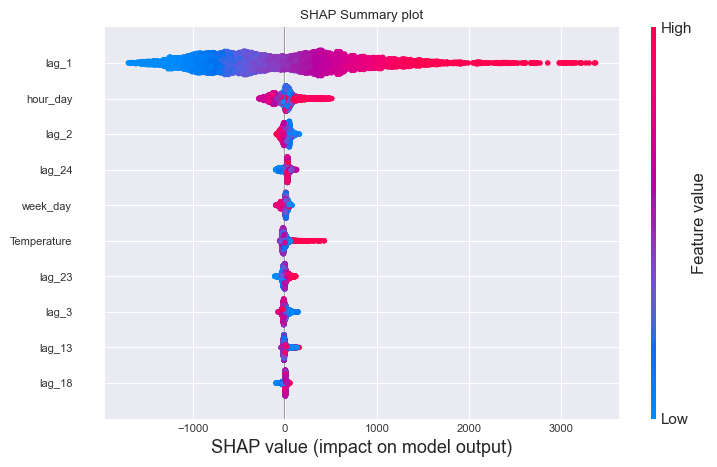

In [76]:
# Shap summary plot (top 10)
# ==============================================================================
shap.summary_plot(shap_values, X_train_sample, max_display=10, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title("SHAP Summary plot")
ax.tick_params(labelsize=8)
fig.set_size_inches(8, 4.5)

In [77]:
# Force plot for the first observation
# ==============================================================================
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train_sample.iloc[0,:])